In [2]:
import random, torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=192, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=192, shuffle=False, num_workers=2)

print("Train batches:", len(trainloader))
print("Test batches:", len(testloader))


Train batches: 313
Test batches: 53


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
def mse_kl_loss(recon_batch, data, mu, logvar):
    recon_loss = F.mse_loss(recon_batch, data, reduction='sum')  
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train_loop(model, trainloader, optimizer):
    model.train()
    total_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = mse_kl_loss(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    average_loss = total_loss / len(trainloader.dataset)
    return average_loss

def evaluate(model, testloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = mse_kl_loss(recon_batch, data, mu, logvar)
            total_loss += loss.item()
    average_loss = total_loss / len(testloader.dataset)
    return average_loss

In [7]:
num_epochs = 10

train_losses = []
test_losses = []

for i in range(1, num_epochs+1):
    print(f"Epoch {i}/{num_epochs}")
    train_loss = train_loop(model, trainloader, optimizer)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss}")
    test_loss = evaluate(model, testloader)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss}")


Epoch 1/10
Train Loss: 551.5756664713541
Test Loss: 532.0451275390625
Epoch 2/10
Train Loss: 534.3993173828125
Test Loss: 532.018244140625
Epoch 3/10
Train Loss: 510.77354856770836
Test Loss: 494.982662890625
Epoch 4/10
Train Loss: 490.7153736979167
Test Loss: 484.284772265625
Epoch 5/10
Train Loss: 484.3339782552083
Test Loss: 481.20522314453126
Epoch 6/10
Train Loss: 482.09263151041665
Test Loss: 479.4094375
Epoch 7/10
Train Loss: 480.81136725260416
Test Loss: 478.60428994140625
Epoch 8/10
Train Loss: 479.93044225260417
Test Loss: 477.81942900390624
Epoch 9/10
Train Loss: 479.1983956380208
Test Loss: 476.9384485351562
Epoch 10/10
Train Loss: 478.6412678385417
Test Loss: 476.5972237304687


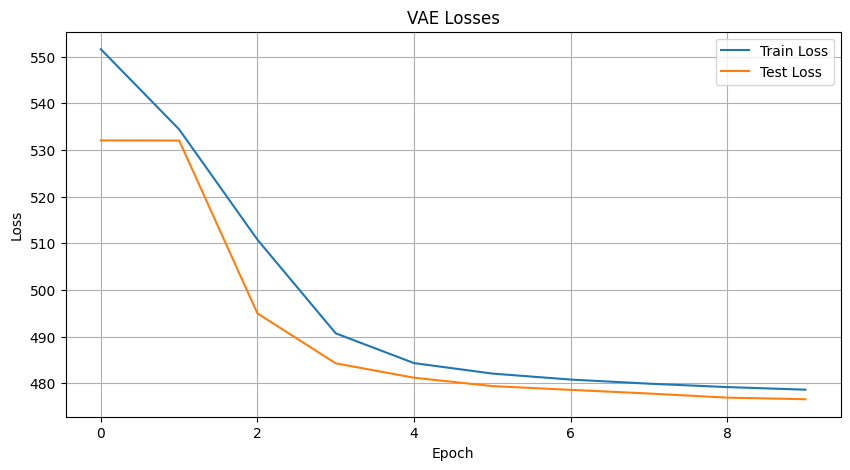

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses")
plt.grid()
plt.legend()
plt.show()

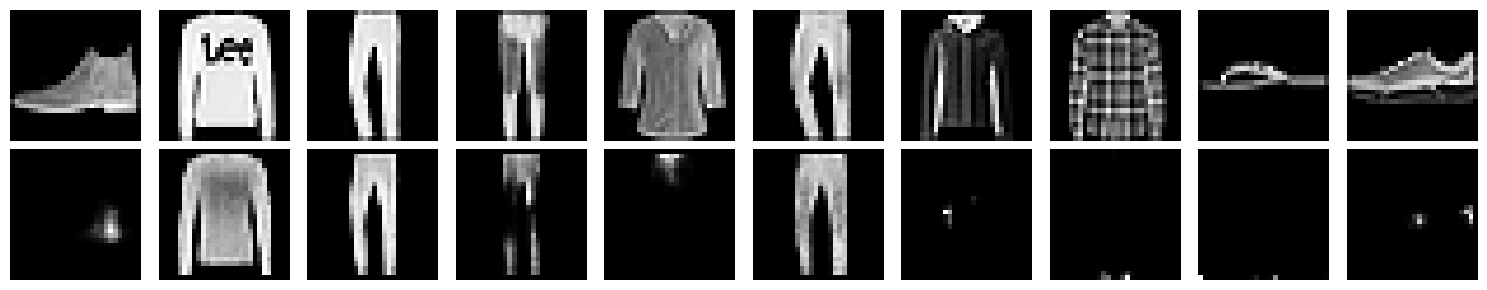

In [9]:
def show_reconstructions(model, data_loader, num_images=10):
    model.eval()
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images].to(device)

    with torch.no_grad():
        recon_images, _, _ = model(images)

    images = images.cpu().numpy()
    recon_images = recon_images.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))

    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstruction")
    plt.tight_layout()
    plt.show()

show_reconstructions(model, testloader)

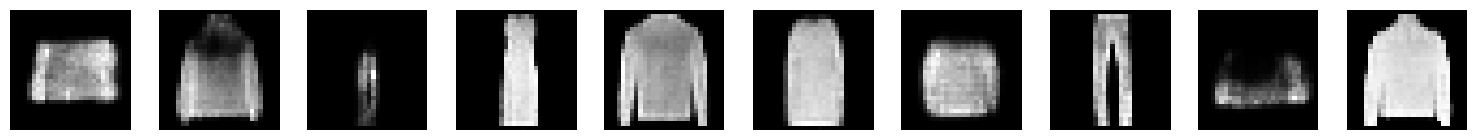

In [ ]:
def show_samples(model, num_images=10, z_dim=20):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, z_dim).to(device)
        samples = model.decode(z).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 1.5, 1.5))
    for i in range(num_images):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(model, num_images=10)

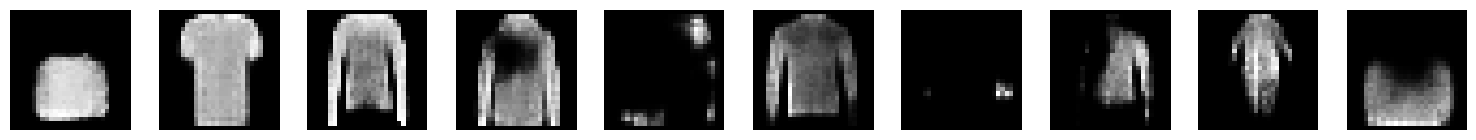

In [ ]:
def show_samples_from_laplace(model, num_images=10, z_dim=20):
    model.eval()
    with torch.no_grad():
        laplace = torch.distributions.Laplace(
            loc=torch.tensor([0.0]).to(device),
            scale=torch.tensor([1.0]).to(device)
        )
        z = laplace.sample((num_images, z_dim)).squeeze(-1).to(device)
        samples = model.decode(z).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 1.5, 1.5))
    for i in range(num_images):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples_from_laplace(model, num_images=10)